# Visualizing Geotopics Results

In this notebook, we provide scripts to visualize the results obtained by the *GeoTopics* method.

**Project Page**: http://mmathioudakis.github.io/geotopics/

**Code Repository**: https://github.com/mmathioudakis/geotopics

## Setup

To visualize the results, you first need to obtain an access token from MapBox and set it as **MAPBOX_ACCESS_TOKEN** environment variable -- or edit this notebook and pass it directly (see below). For instructions on how to obtain an access token, see the [official Mapbox instructions](https://www.mapbox.com/developers/).

In what follows, we first import the required libraries and define constants and various functions.

In [1]:
# required libraries
import enum
import gc
import matplotlib.cm as cmlib
import numpy as np
import persistent as p
import sys
import shapely.geometry as g
import shapely.speedups
import visualization.scatter_plot as scplot
import visualization.utils as scatter_utils
from poly_gaussian import gaussian_to_poly
import matplotlib.pyplot as plt
import mapbox
import matplotlib.image as mpimg
import os

/Users/mathiom1/anaconda/lib/python3.5/site-packages/sklearn/utils/fixes.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


In [2]:
%matplotlib inline

In [3]:
mapbox_service = mapbox.Static()
service.session.params['access_token'] = os.environ['MAPBOX_ACCESS_TOKEN']

# alternatively, you can uncomment the next line and pass your token directly
# mapbox_service.session.params['access_token'] = 'YOUR_TOKEN'

In [4]:
mainCats = ['Arts & Entertainment', 'College & University', 'Food', 'Nightlife Spot',
        'Outdoors & Recreation', 'Shop & Service', 'Professional & Other Places',
        'Residence', 'Travel & Transport']
main_cats_plot = mainCats[:]
mainCats = {c: i for i, c in enumerate(mainCats)}
mainCats['Event'] = 9

name_to_main_cat = p.load_var('name_to_cat.my')
name_to_main_cat['Event'] = 'Event'
name_to_main_cat['NOPRIMCAT'] = 'Event'
name_to_main_cat['Tennis'] = 'Outdoors & Recreation'

timeOfDay = ['MORNING', 'NOON', 'AFTERNOON', 'EVENING', 'NIGHT', 'LATENIGHT']
timeOfDay_plot = ['MORN', 'NOON', 'AFNN', 'EVEN', 'NGHT', 'LATE']
dayOfWeek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dayOfWeek_plot = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [5]:
FOLDER = 'data/'
city = 'firenze'

In [6]:
def iter_region_distribution_and_geo(model, cat_idx_to_main_idx,
                                     timeOfDay_order, dayOfWeek_order):
    """Generate distributions for each region."""
    params = model.get_params()
    thetas = params.theta[0]
    category_distr = get_distributions_for_dimension(params, 'primCategory')
    timeofday_distr = get_distributions_for_dimension(params, 'timeOfDay')
    dayofweek_distr = get_distributions_for_dimension(params, 'dayOfWeek')
    centers = params.topic_centers
    covars = params.topic_covar

    assert(category_distr[0].shape == category_distr[1].shape)
    assert(timeofday_distr[0].shape == timeofday_distr[1].shape)
    num_of_regions = params.num_topics
    for z in range(num_of_regions):
        cat_distr, cat_distinct = reorder_category(category_distr[0][z],
                                                   cat_idx_to_main_idx, category_distr[1][z])
        yield (z, thetas[z], cat_distr, cat_distinct,
               timeofday_distr[0][z][timeOfDay_order],
               timeofday_distr[1][z][timeOfDay_order],
               dayofweek_distr[0][z][dayOfWeek_order],
               dayofweek_distr[1][z][dayOfWeek_order],
               centers[z], covars[z])

def get_distributions_for_dimension(params, dimension):
    # retrieve model parameters
    h_array = params.h_arrays[dimension]
    beta_distr = params.beta_arrays[dimension]
    # exponentiate logs
    distinctiveness_ratio = np.exp(h_array)
    return beta_distr, distinctiveness_ratio

def reorder_category(distrib, cat_idx_to_main_idx, distinct):
    category_freq = np.zeros(9)  # skip Event category
    category_distinct = np.zeros_like(category_freq)
    for i in range(category_freq.size):
        relevant_subcat = cat_idx_to_main_idx == i
        category_freq[i] = distrib[relevant_subcat].sum()
        category_distinct[i] = np.sum(distinct[relevant_subcat]*distrib[relevant_subcat])
    return category_freq / category_freq.sum(), category_distinct


class ScoreType(enum.Enum):
    likely = 0
    distinctive = 1


class PrettyFloat(float):
    def __repr__(self):
        return '%.5f' % self

def pretty_floats(obj):
    if isinstance(obj, float):
        return PrettyFloat(obj)
    elif isinstance(obj, dict):
        return dict((k, pretty_floats(v)) for k, v in obj.items())
    elif isinstance(obj, (list, tuple)):
        return list(map(pretty_floats, obj))
    return obj

In [7]:
prefix = FOLDER + city
# filenames
model_file = prefix + ".mdl"
scaler_file = prefix + ".scaler"
unigrams_file = prefix + ".unigrams"
# load data
model = p.load_var(model_file)
scaler = p.load_var(scaler_file)
unigrams = p.load_var(unigrams_file)

cat_idx_to_main_idx = np.array([mainCats[name_to_main_cat[cat_name]]
                                for distrib_idx, cat_name
                                in enumerate(unigrams['primCategory'])])
timeOfDay_order = [unigrams['timeOfDay'].index(_) for _ in timeOfDay]
dayOfWeek_order = [unigrams['dayOfWeek'].index(_) for _ in dayOfWeek]

msg = 'Processing {} regions in {}'
print(msg.format(model.get_params().num_topics, city))

neighborhoods = []
# iterate over regions, extract the distributions for each
for x in iter_region_distribution_and_geo(model, cat_idx_to_main_idx,
                                          timeOfDay_order, dayOfWeek_order):
    (region_id, theta, cat_distr, cat_distinct, timeofday_distr,
     timeofday_distinct, dayofweek_distr, dayofweek_distinct, center,
     covar) = x
    geojson = gaussian_to_poly(center, covar, city,
                               'Region {:02}'.format(region_id + 1),
                               scaler, resolution=26)
    del geojson['properties']['city']
    del geojson['properties']['fill']
    geojson['properties']['category_distrib'] = list(cat_distr)
    geojson['properties']['category_more'] = list(cat_distinct)
    geojson['properties']['time_distrib'] = list(timeofday_distr)
    geojson['properties']['time_more'] = list(timeofday_distinct)
    geojson['properties']['days_distrib'] = list(dayofweek_distr)
    geojson['properties']['days_more'] = list(dayofweek_distinct)
    geojson['properties']['weight'] = float(theta)
    neighborhoods.append(geojson)
neighborhoods.sort(key=lambda x: x['properties']['weight'], reverse=True)
a = pretty_floats({"type": "FeatureCollection",
                   "features": neighborhoods})

Processing 8 regions in firenze


In [8]:
cat_colors = [cmlib.Oranges(x) for x in np.linspace(0, 1, len(main_cats_plot))]
time_colors = [cmlib.Greens(x) for x in np.linspace(0, 1, len(timeOfDay))]
day_colors = [cmlib.Purples(x) for x in np.linspace(0, 1, len(dayOfWeek))]

## Plotting

In [9]:
# select top regions based on volume
MAX_REGIONS = 5
results = sorted(enumerate(a['features']), key = lambda x: x[1]['properties']['weight'], reverse = True)[:MAX_REGIONS]

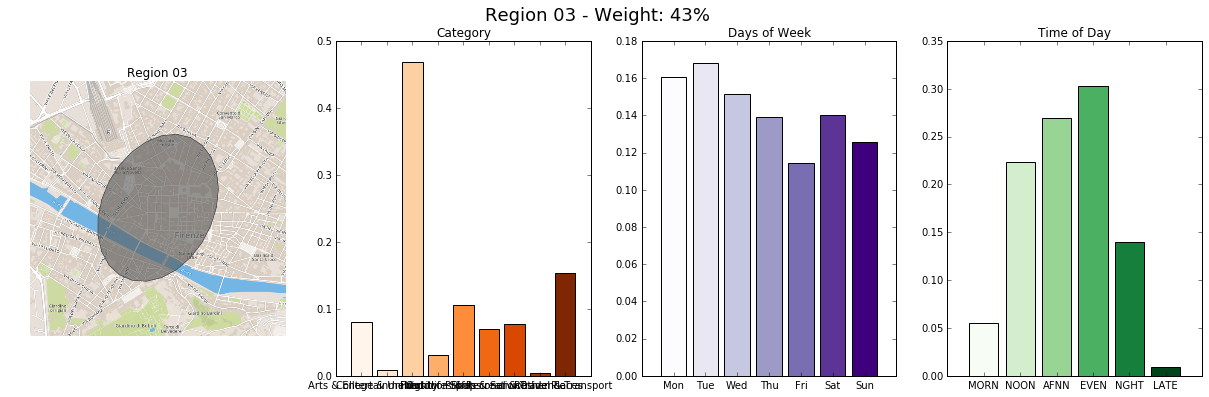

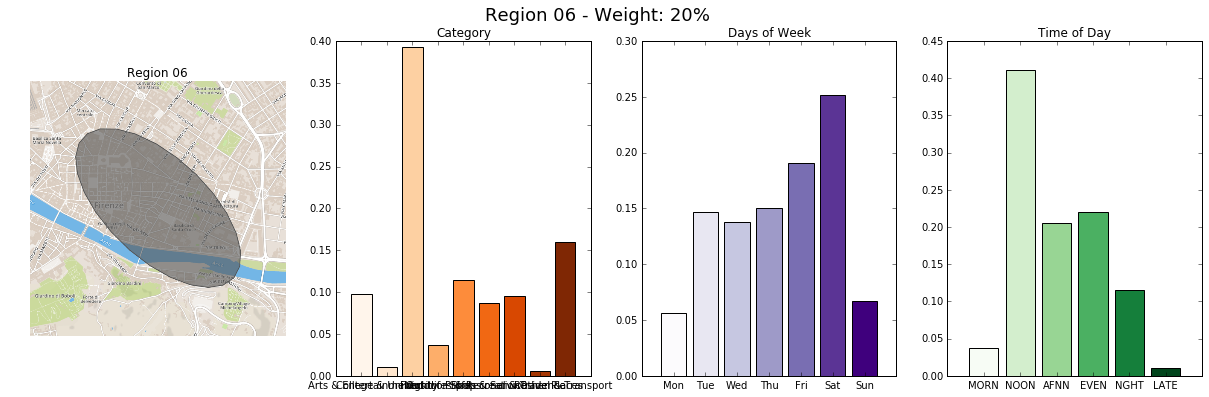

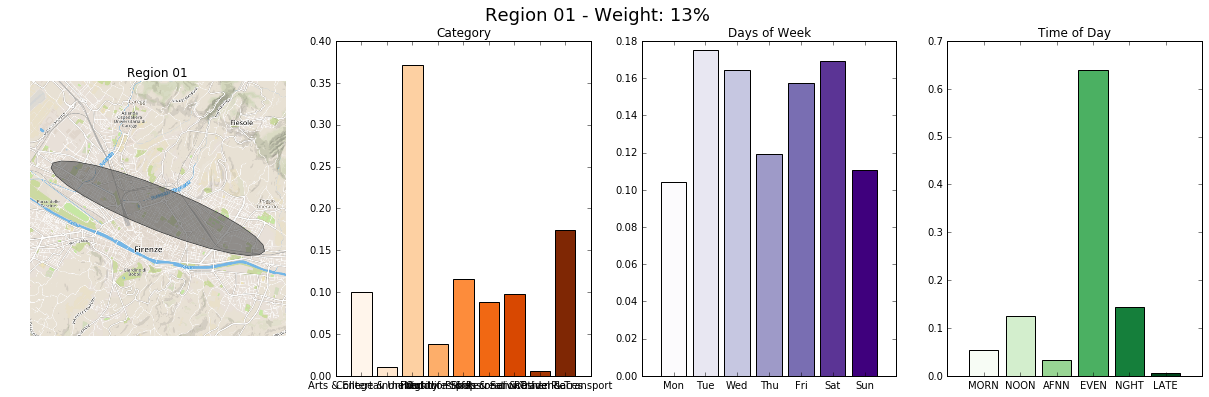

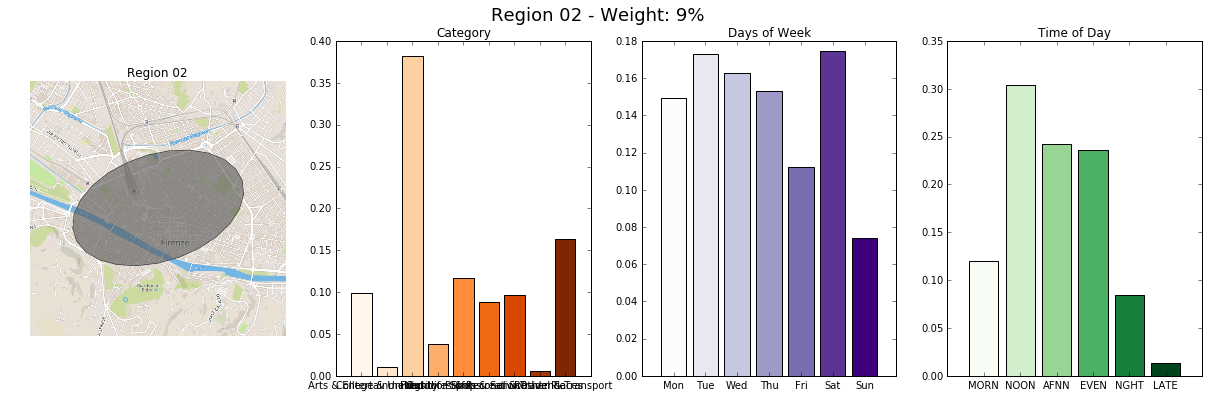

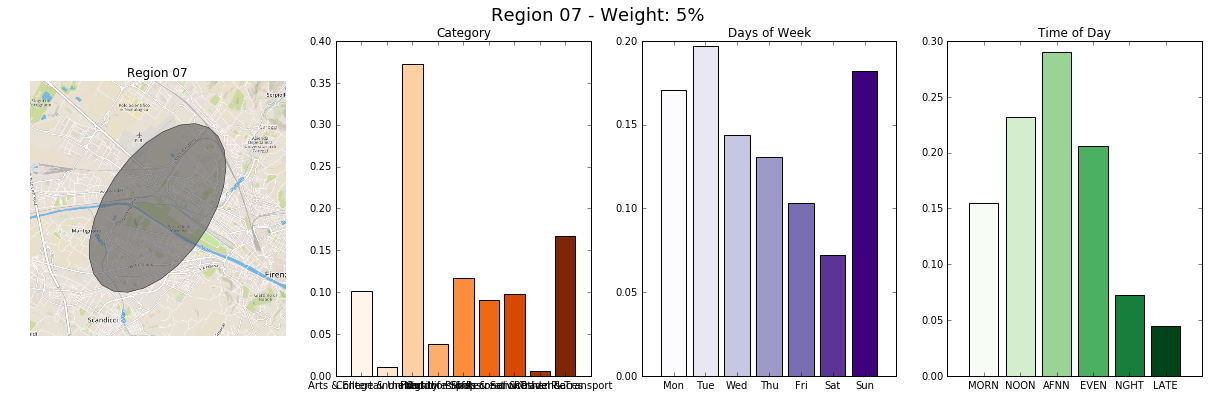

In [10]:
for region_id, res in results:
    stats = res['properties']
    
    fig, ax = plt.subplots(1, 4, figsize = (21, 6))
    fig.suptitle("{} - Weight: {}%".format(stats['name'], int(100 * stats['weight'])), size = 18)
    
    ax[0].set(title = stats['name'])
    response = mapbox_service.image('mapbox.streets', features=[a['features'][region_id]])
    with open('/tmp/map.png', 'wb') as output:
        _ = output.write(response.content)
    img = mpimg.imread('/tmp/map.png')
    ax[0].axis('off')
    ax[0].imshow(img);
    
    
    ax[1].set(title = 'Category')
    ax[1].bar(range(len(mainCats) - 1), stats['category_distrib'], tick_label = main_cats_plot,
              color = cat_colors, align = 'center')
    
    ax[2].set(title = 'Days of Week')
    ax[2].bar(range(len(dayOfWeek)), stats['days_distrib'], tick_label = dayOfWeek_plot,
              color = day_colors, align = 'center')
    
    ax[3].set(title = 'Time of Day')
    ax[3].bar(range(len(timeOfDay)), stats['time_distrib'], tick_label = timeOfDay_plot,
              color = time_colors, align = 'center')
